# Relevant Libraries

In [ ]:
# plotting
import matplotlib.pyplot as plt
!pip install -U kaleido
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# data processing
import numpy as np
import pandas as pd
import json
import ast

# linking to google drive
from google.colab import drive
drive.mount('/content/drive')

# linking to google sheet
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# Plotting line graphs for training

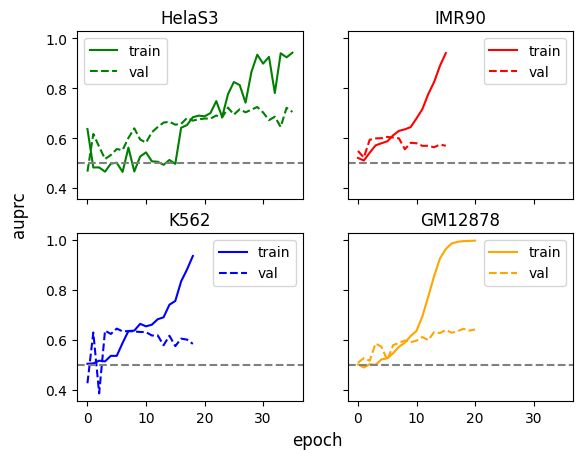

In [ ]:
# Required input: JSON files of training

all_data = ["HelaS3", "IMR90", "K562", "GM12878"]
color = ["green", "red", "blue", "orange"]
color_index = 0

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
axes_index = 0

for data_name in all_data:
  with open(f"model4_{data_name}.json") as result_json:   # model_name
    result = json.load(result_json)
    x = list(range(len(result['auprc'])))
    y = result['auprc']
    axs.flat[axes_index].plot(x, y, label = f"train", color = color[color_index])

    x = list(range(len(result['val_auprc'])))
    y = result['val_auprc']
    axs.flat[axes_index].plot(x, y, label = f"val", color = color[color_index], linestyle="--")

    axs.flat[axes_index].set_title(data_name)
    axs.flat[axes_index].axhline(0.5,color='grey',ls='--')
    axs.flat[axes_index].legend()

  color_index += 1
  axes_index += 1

fig.supxlabel("epoch")
fig.supylabel("auprc")

fig.show()

# Plotting Dataset Distribution

{'HelaS3': 0.16666666666666666, 'K562': 0.16689905186837703, 'IMR90': 0.1670324846356453, 'GM12878': 0.16666666666666666}


Text(0.5, 1.0, 'Number of rows in each dataset')

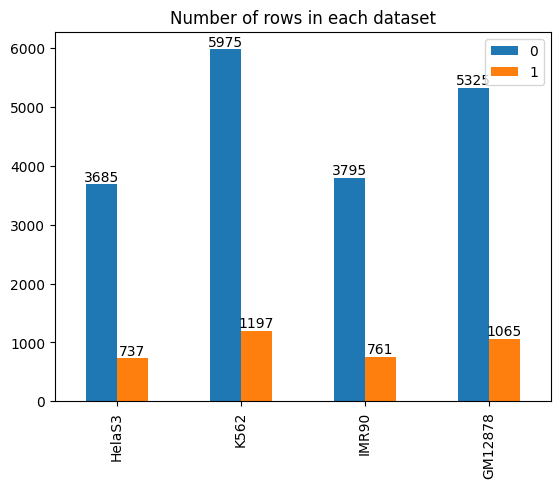

In [ ]:
datasets = {
    "HelaS3": pd.read_csv("/content/drive/MyDrive/FYP/data_fuying/fuying_HelaS3_out_fea_DNA.csv"),
    "K562": pd.read_csv("/content/drive/MyDrive/FYP/data_fuying/fuying_K562_out_fea_DNA.csv"),
    "IMR90": pd.read_csv("/content/drive/MyDrive/FYP/data_fuying/fuying_IMR90_out_fea_DNA.csv"),
    "GM12878": pd.read_csv("/content/drive/MyDrive/FYP/data_fuying/fuying_GM12878_out_fea_DNA.csv")
  }

number_of_data_points = {
  dataset_name: dataframe['label'].value_counts() for dataset_name, dataframe in datasets.items()
}

baseline = {
      dataset_name: value_counts[1]/(value_counts[0] + value_counts[1]) for dataset_name, value_counts in number_of_data_points.items()
    }

print(baseline)

ax = pd.DataFrame(number_of_data_points).transpose().plot(kind='bar')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.set_title("Number of rows in each dataset")

# Different Model

In [ ]:
def plot_boxplot_and_barplot(plot_df_boxplot, plot_df_barplot, title = "Model Performances", output_file_name = "output"):
  fig = px.box(
      plot_df_boxplot,
      x="dataset",
      y="value",
      color="model",
      labels={
        "value": "Average Test AuPRC",
      },
      title=title)
  fig.add_hline(y=0.1666,
                annotation_text="Baseline",
                annotation_position="bottom left")
  fig.update_yaxes(rangemode="tozero", range=[0, 1])
  fig.update_layout(
    title = dict(
        x = 0,
        y = 1
    ),
    legend=dict(
        x=0,
        y=1,
        yanchor = "bottom",
    )
  )
  fig.show()

  fig.write_html(f"/content/drive/MyDrive/FYP/figures/boxplot_{output_file_name}.html")
  fig.write_html(f"boxplot_{output_file_name}.html")
  fig.write_image(f"/content/drive/MyDrive/FYP/figures/boxplot_{output_file_name}.png")
  fig.write_image(f"boxplot_{output_file_name}.png")


  fig = px.bar(
      plot_df_barplot,
      x="dataset",
      y="avg auprc",
      color='model',
      barmode='group',
      # histfunc='avg',
      labels={
        "avg auprc": "Average Test AuPRC",
      },
      title=title)
  fig.add_hline(y=0.1666,
                annotation_text="Baseline",
                annotation_position="bottom left")
  fig.update_layout(
    title = dict(
        x = 0,
        y = 1
    ),
    legend=dict(
        x=0,
        y=1,
        yanchor = "bottom",
    )
)
  fig.update_yaxes(rangemode="tozero", range=[0, 1])
  fig.show()

  fig.write_image(f"/content/drive/MyDrive/FYP/figures/barplot_{output_file_name}.png")
  fig.write_html(f"/content/drive/MyDrive/FYP/figures/barplot_{output_file_name}.html")
  fig.write_image(f"barplot_{output_file_name}.png")
  fig.write_html(f"barplot_{output_file_name}.html")

def plot_best_models(model_names, title, output_file_name):
  worksheet = gc.open('Result Different Model').sheet1

  # get_all_values gives a list of rows.
  rows = worksheet.get_all_values()

  # Convert to a DataFrame and render.
  df = pd.DataFrame.from_records(rows[1:], columns = rows[0])

  df["avg auprc"] = pd.to_numeric(df["avg auprc"])
  auprc_cols = pd.DataFrame(df['test auprc'].apply(ast.literal_eval).to_list(), columns=["auprc" + str(i) for i in range(10)])
  temp_df = pd.concat([df[["dataset", "model"]], auprc_cols], axis = 1)

  plot_df_boxplot = pd.melt(temp_df, id_vars=['dataset', 'model'], value_vars=["auprc" + str(i) for i in range(10)])

  plot_df_barplot = df[["dataset", "model", "avg auprc"]]

  plot_boxplot_and_barplot(plot_df_boxplot, plot_df_barplot, title, output_file_name)

In [ ]:
plot_best_models(
    title = "Performances of Models using RNA-Seq Gene Expression",
    output_file_name = "RNA_GE",
    )

# Different Anchor Length

In [ ]:
worksheet = gc.open('Result Different Anchor Length').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

# Convert to a DataFrame and render.
source_data = pd.DataFrame.from_records(rows[1:], columns = rows[0])
source_data.len_RNA = pd.Categorical(
    source_data.len_RNA,
    categories=["4000", "8000", "12000", "16000", "20000", "30000", "40000"],
    ordered=True
)
source_data["avg auprc"] = pd.to_numeric(
    source_data["avg auprc"]
)

df = pd.DataFrame()
for model_name in ["model_15_2_layer_64_128_CNN_1_layer_transformer_encoder_4_layer_FFN"]:
  # data = source_data[source_data["model"].str.startswith(model_name + "_")]
  data = source_data[source_data["model"] == model_name]
  df = pd.concat([df, data])

df = df.reset_index(drop = True).sort_values(["len_RNA"])

fig = px.line(
    df,
    x='len_RNA',
    y='avg auprc',
    color='model',
    facet_col='dataset',
    facet_col_wrap=2,
    markers = True
)
fig.update_layout(
    height=800,
    width=1000,
    title_text="Model Performance using Different Anchor Length",
    yaxis1 = dict(range=[0, 1], title_text="Mean AuPRC", dtick=0.1),
    yaxis2 = dict(range=[0, 1], dtick=0.1),
    yaxis3 = dict(range=[0, 1], title_text="Mean AuPRC", dtick=0.1),
    yaxis4 = dict(range=[0, 1], dtick=0.1),
    xaxis1 = dict(title_text = "RNA Anchor Length"),
    xaxis2 = dict(title_text = "RNA Anchor Length"),
    # xaxis3 = dict(title_text = "RNA Anchor Length"),
    # xaxis4 = dict(title_text = "RNA Anchor Length"),
    title = dict(
        x = 0,
        y = 1
    ),
    legend=dict(
        x=0,
        y=-0.1,
        yanchor = "top",
    ),
    showlegend=False
)
fig.add_hline(y=0.1666,
  annotation_text="Baseline",
  annotation_position="bottom left"
)
fig.show()
fig.write_image(f"multiple_length.png")

# Chrom-split vs Random-split

In [ ]:
worksheet = gc.open('Result Chrom-split Random-split').sheet1
rows = worksheet.get_all_values()
df = pd.DataFrame.from_records(rows[1:], columns = rows[0])

df["avg auprc"] = pd.to_numeric(df["avg auprc"])
fig = px.bar(
      df,
      x="dataset",
      y="avg auprc",
      color='split',
      barmode='group',
      # histfunc='avg',
      labels={
        "avg auprc": "Average Test AuPRC",
      },
      text_auto=".4f",
      title="Model Performance using Different Split Strategy")
fig.add_hline(y=0.1666,
              annotation_text="Baseline",
              annotation_position="bottom left")
fig.update_layout(
  title = dict(
      x = 0,
      y = 1
  ),
  legend=dict(
      x=0,
      y=1,
      yanchor = "bottom",
  )
)
fig.update_yaxes(rangemode="tozero", range=[0, 1], dtick = 0.1)
fig.show()

# fig.write_image(f"/content/drive/MyDrive/FYP/figures/barplot_{output_file_name}.png")
# fig.write_html(f"/content/drive/MyDrive/FYP/figures/barplot_{output_file_name}.html")
fig.write_image(f"barplot_split.png")
fig.write_html(f"barplot_split.html")